In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, binned_statistic, wilcoxon
from settings import colors

In [2]:
mplego.style.use_latex_style()

In [4]:
exp = 10
base_path = f"/storage/noise_correlations/exp{exp}"

In [7]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp10_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp10_ecog_20_3000_1000.h5')

In [8]:
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ret2 = h5py.File(ret2_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [9]:
n_results = len(results)
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [7]:
with open(os.path.join(base_path, 'exp10_cdfs.pkl'), 'rb') as f:
    all_null_equiv_cdfs, all_opt_fa_equiv_cdfs, all_opt_equiv_cdfs = pickle.load(f)
all_null_equiv_cdfs = [all_null_equiv_cdfs[3], all_null_equiv_cdfs[0], all_null_equiv_cdfs[4]]
all_opt_fa_equiv_cdfs = [all_opt_fa_equiv_cdfs[3], all_opt_fa_equiv_cdfs[0], all_opt_fa_equiv_cdfs[4]]
all_opt_equiv_cdfs = [all_opt_equiv_cdfs[3], all_opt_equiv_cdfs[0], all_opt_equiv_cdfs[4]]

In [8]:
# Calculate correlations between max CDFs and percentiles
null_corrs_fa = np.zeros((len(results), dims.size))
null_corrs_r = np.zeros((len(results), dims.size))
fa_corrs = np.zeros((len(results), dims.size))
r_corrs = np.zeros((len(results), dims.size))

for result_idx, result in enumerate(results):
    for dim_idx, dim in enumerate(dims):
        null_corrs_r[result_idx, dim_idx] = spearmanr(
            result['p_r_lfi'][dim_idx],
            np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1),
        ).correlation
        null_corrs_fa[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1),
        ).correlation
        fa_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1),
        ).correlation
        r_corrs[result_idx, dim_idx] = spearmanr(
            result['p_r_lfi'][dim_idx],
            np.max(all_opt_equiv_cdfs[result_idx][dim], axis=-1),
        ).correlation

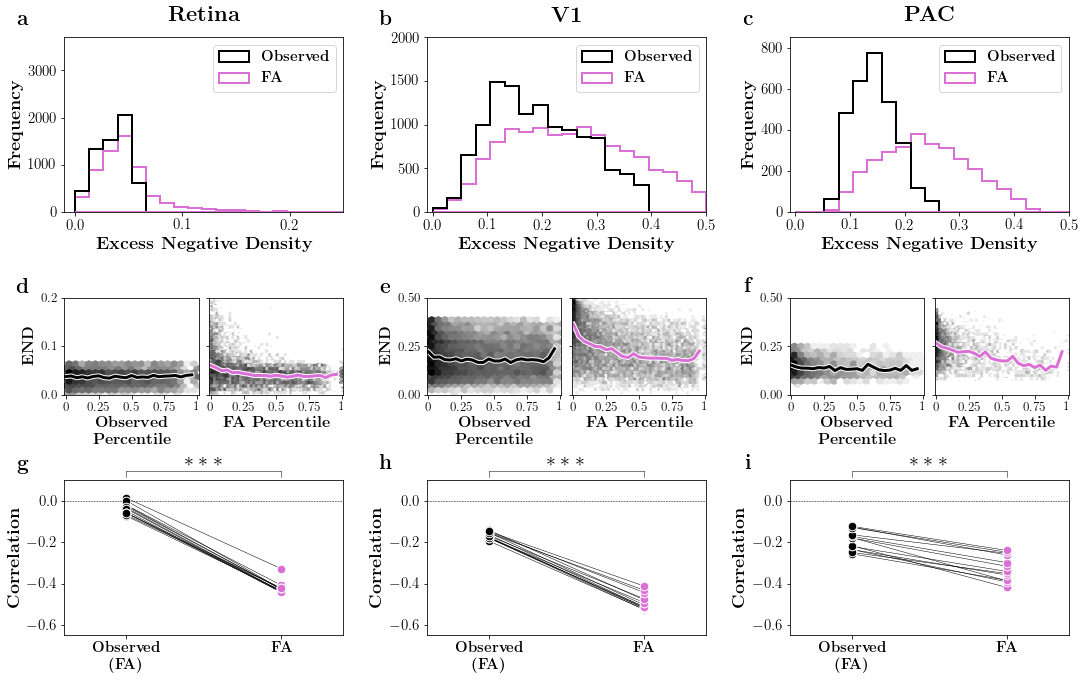

In [34]:
"""
Plot Settings
"""
result_idxs = [0, 3, 4]
dim_idx = 0
dim = dim_idx + 3

# Figure settings
figsize = (18, 11)
height_ratios = [0.9, 0.5, 0.8]
hspace = 0.6
wspace = 0.3
inner_wspace = 0.08
inner_hspace = 0.15
title_pad = 15
subplot_x = -0.15
subplot_y = 1.10

# Histograms
max_cdf_bins = [
    np.linspace(0, 0.25, 20),
    np.linspace(0, 0.5, 20),
    np.linspace(0, 0.5, 20)]
max_cdf_hist_lw = 2

# Hexbins
gridsize = 20
stat_binned_bins = np.linspace(0, 1, 25)
extents = [
    (0., 1., 0., 0.2),
    (0., 1., 0., 0.5),
    (0., 1., 0., 0.5)
]
binned_lw = 3
binned_edge_lw = 5

# Scatter settings
markersize = 75
compare_lw = 0.5

# Label sizes
title_size = 22
axis_label_size = 18
axis_tick_size = 15
inner_tick_size = 13
inner_label_size = 16
subplot_label_size = 21

# Labels
model_labels = mplego.labels.bold_text(['Observed', 'FA'])
label_dict = {'observed': model_labels[0], 'fa': model_labels[1]}

# Maximum values
max_null_cdfs = [np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
                 for result_idx in range(n_results)]
max_opt_fa_cdfs = [np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
                   for result_idx in range(n_results)]


"""
Figure 7
"""
# Create figure
fig = plt.figure(figsize=figsize)
# Create grid spec
spec = fig.add_gridspec(
    ncols=3,
    nrows=3,
    height_ratios=height_ratios,
    hspace=hspace,
    wspace=wspace)
top_row = []
middle_row = []
dummy_row = []
bottom_row = []

# Create plot, one column at a time (per dataset)
for ii, result in enumerate(results):
    # Get percentiles
    fa_percentiles = result['p_fa_lfi'][dim_idx]
    r_percentiles = result['p_r_lfi'][dim_idx]

    # Row 1: Max CDF histograms
    max_cdf_ax = fig.add_subplot(spec[0, ii])
    max_cdf_ax.hist(
        [max_null_cdfs[ii],
         max_opt_fa_cdfs[ii]],
        histtype='step',
        color=[colors['observed'], colors['fa']],
        lw=max_cdf_hist_lw,
        bins=max_cdf_bins[ii])
    for key, label in label_dict.items():
        max_cdf_ax.hist([], color=colors[key], label=label, histtype='step', lw=max_cdf_hist_lw)
    max_cdf_ax.legend(
        loc='best',
        prop={'size': 15})
    top_row.append(max_cdf_ax)
    
    # Row 2: Max CDFs vs. Percentiles
    dummy = fig.add_subplot(spec[1, ii])
    dummy.axis('off')
    dummy_row.append(dummy)

    inner_grid = spec[1, ii].subgridspec(1, 2, wspace=inner_wspace, hspace=inner_hspace)
    axes = inner_grid.subplots(sharex=True, sharey=True)

    axes[0].hexbin(
        fa_percentiles,
        max_null_cdfs[ii],
        bins='log',
        gridsize=gridsize,
        cmap='Greys',
        extent=extents[ii])
    axes[1].hexbin(
        result['p_fa_lfi'][dim_idx],
        np.max(all_opt_fa_equiv_cdfs[ii][dim], axis=-1),
        bins='log',
        gridsize=50,
        cmap='Greys',
        extent=extents[ii])

    # Calculate binned statistics for lines
    stat_null_fa, _, _ = binned_statistic(
        fa_percentiles,
        max_null_cdfs[ii],
        bins=stat_binned_bins,
        statistic='median')
    stat_null_r, _, _ = binned_statistic(
        r_percentiles,
        max_null_cdfs[ii],
        bins=stat_binned_bins,
        statistic='median')
    stat_fa, _, _ = binned_statistic(
        fa_percentiles,
        max_opt_fa_cdfs[ii],
        bins=stat_binned_bins,
        statistic='median')
    stat_r, _, _ = binned_statistic(
        r_percentiles,
        max_opt_r_cdfs[ii],
        bins=stat_binned_bins,
        statistic='median')
    # Plot binned statistics, with borders

    axes[0].plot(
        stat_binned_bins[:-1],
        stat_null_fa,
        color='white',
        lw=binned_edge_lw)
    axes[0].plot(
        stat_binned_bins[:-1],
        stat_null_fa,
        color=colors['observed'],
        lw=binned_lw)

    axes[1].plot(
        stat_binned_bins[:-1],
        stat_fa,
        color='white',
        lw=binned_edge_lw)
    axes[1].plot(
        stat_binned_bins[:-1],
        stat_fa,
        color=colors['fa'],
        lw=binned_lw)


    middle_row.append(axes)

    # Row 3: Correlation comparisons
    ax = fig.add_subplot(spec[2, ii])
    for jj in range(dims.size):
        ax.plot(
            [0, 1],
            [null_corrs_fa[ii, jj], fa_corrs[ii, jj]],
            color=colors['observed'],
            lw=compare_lw)

    ax.scatter(
        np.zeros(dims.size),
        null_corrs_fa[ii],
        color=colors['observed'],
        edgecolor='white',
        zorder=1000,
        s=markersize)
    ax.scatter(
        np.ones(dims.size),
        fa_corrs[ii],
        color=colors['fa'],
        edgecolor='white',
        s=markersize,
        zorder=1000)

    bottom_row.append(ax)

# Axis ticks, labels, and additional settings
top_row[0].set_title(r'\textbf{Retina}', fontsize=title_size, pad=title_pad)
top_row[1].set_title(r'\textbf{V1}', fontsize=title_size, pad=title_pad)
top_row[2].set_title(r'\textbf{PAC}', fontsize=title_size, pad=title_pad)

for ax in top_row:
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_xlabel(r'\textbf{Excess Negative Density}', fontsize=axis_label_size)
    ax.set_ylabel(r'\textbf{Frequency}', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)
top_row[0].set_xlim([-0.01, 0.25])
top_row[0].set_ylim([0, 3700])
top_row[0].set_yticks([0, 1000, 2000, 3000])
top_row[1].set_xlim([-0.01, 0.5])
top_row[1].set_ylim([0, 2000])
top_row[1].set_yticks([0, 500, 1000, 1500, 2000])
top_row[2].set_xlim([-0.01, 0.5])
top_row[2].set_ylim([0, 850])
top_row[2].set_yticks([0, 200, 400, 600, 800])

for ax in middle_row:
    ax[0].set_xlim([-0.01, 1.01])
    ax[0].set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax[0].set_xticklabels(['0', 0.25, 0.5, 0.75, '1'])
    ax[1].tick_params(labelsize=inner_tick_size)
    ax[1].set_xlim([-0.01, 1.01])
    ax[1].set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax[1].set_xticklabels(['0', 0.25, 0.5, 0.75, '1'])
    ax[1].tick_params(labelsize=inner_tick_size)
    ax[0].set_xlabel(r'\textbf{Observed}' '\n' r'\textbf{Percentile}', fontsize=inner_label_size)
    ax[1].set_xlabel(r'\textbf{FA Percentile}', fontsize=inner_label_size)
    ax[0].set_ylabel(r'\textbf{END}', fontsize=inner_label_size)

middle_row[0][0].set_ylim([0, 0.2])
middle_row[0][0].set_yticks([0, 0.1, 0.2])
middle_row[0][0].tick_params(labelsize=inner_tick_size)
middle_row[1][0].set_ylim([0, 0.5])
middle_row[1][0].set_yticks([0, 0.25, 0.5])
middle_row[1][0].tick_params(labelsize=inner_tick_size)
middle_row[2][0].set_ylim([0, 0.5])
middle_row[2][0].set_yticks([0, 0.25, 0.5])
middle_row[2][0].tick_params(labelsize=inner_tick_size)

for ax in bottom_row:
    ax.set_xlim([-0.4, 1.4])
    ax.set_xticks([0, 1])
    ax.set_xticklabels([r'\textbf{Observed}' '\n' r'\textbf{(FA)}', r'\textbf{FA}'])
    ax.set_ylim([-0.65, 0.1])
    ax.tick_params(labelsize=axis_tick_size)
    ax.axhline(0, color='black', linestyle='--', lw=0.5)
    ax.set_ylabel(r'\textbf{Correlation}', fontsize=axis_label_size)
    mplego.labels.add_significance_label(ax, bounds=[0, 1], label=r'$***$', lw=0.5, spacing=0.02, width=0.04)

mplego.labels.apply_subplot_labels(
    top_row + dummy_row + bottom_row,
    bold=True,
    size=subplot_label_size,
    x=subplot_x,
    y=subplot_y)

plt.savefig('figure6.pdf', bbox_inches='tight')
plt.show()